In [125]:
%matplotlib inline

In [126]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPool2D, UpSampling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K

# Road Segmentation from Aerial Imagery
## Segmentating Images with a Encoder-Decoder model
### Dataset: https://competitions.codalab.org/competitions/18467

In [128]:
np.random.seed(1)

##Hyper-parameters and other config options

In [129]:
DATA_DIR = "data/"
TRAIN_DIR = DATA_DIR + "train/"
TEST_DIR = DATA_DIR + "test/"
INPUT_IMAGE_SIZE = (1024, 1024, 3)

# Hyper-parameters
IMAGE_SIZE = (512, 512, 3)

BATCH_SIZE = 32
EPOCHS = 200
STEPS_PER_EPOCH = 1

LEARNING_RATE = 0.0001

TVERSKY_ALPHA = 0.5
FOCAL_TVERSKY_GAMMA = 0.1

## Loading the training and data from the dataset
The dataset consists of a training directory with images labeoled with an unique identificator and either "sat" or "mask" for respectively the image and ground truth mask.

In [130]:
if not os.path.exists(DATA_DIR):
    os.makedirs(DATA_DIR)

In [131]:
def get_frames_with_masks(data_dir):
  frames_with_masks = []
  for filename in os.listdir(data_dir):
    id = filename.split('_')[0]
    frame = data_dir + id + "_sat.jpg"
    mask = data_dir + id + "_mask.png"
    if os.path.isfile(frame) and os.path.isfile(mask):
      frames_with_masks.append((frame, mask))
  return frames_with_masks

In [132]:
def get_frames(data_dir):
  frames = []
  for filename in os.listdir(data_dir):
    if "sat" in filename:
      frames.append(data_dir + filename)
  return frames

In [133]:
train_ds = tf.data.Dataset.from_tensor_slices(get_frames_with_masks(TRAIN_DIR))

In [134]:
for image, mask in train_ds:
    print(image)
    print(mask)
    break

tf.Tensor(b'data/train/806315_sat.jpg', shape=(), dtype=string)
tf.Tensor(b'data/train/806315_mask.png', shape=(), dtype=string)


In [135]:
def load_train(image_with_mask) -> tuple:
    image = image_with_mask[0]
    mask = image_with_mask[1]
    
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image)
    image.set_shape(INPUT_IMAGE_SIZE)

    mask = tf.io.read_file(mask)
    mask = tf.io.decode_image(mask)
    mask.set_shape(INPUT_IMAGE_SIZE)
    mask = tf.image.rgb_to_grayscale(mask)
    return (image, mask)

In [136]:
def load_test(image):
    image = tf.io.read_file(image)
    image = tf.io.decode_image(image)
    image.set_shape(INPUT_IMAGE_SIZE)
    return image

In [137]:
def to_dictionary(image, mask):
    data = (image, mask)
    return data

In [138]:
train_ds = train_ds.map(load_train)

In [139]:
train_ds = train_ds.map(to_dictionary)

## Rescaling and Resizing the training data
The data is normalized using tensorflow.keras.preprocessing. The images in the dataset are 1024 x 1024 x 3 (RGB), but the model's input is 512 x 512 x 3 (RGB) and the masks are converted to grayscale, because we only have two classes (background and road), so the output of the model is 512 x 512 x 1. 0 for black (background) and 1 for white (road).

In [140]:
normalize = Sequential([
    preprocessing.Resizing(512, 512),
    preprocessing.Rescaling(1./255)
])

In [141]:
def normalize_train(image, mask):
    image = normalize(image)
    mask = normalize(mask)
    return image, mask

In [142]:
def normalize_test(image):
    image = normalize(image)
    return image

In [143]:
train_ds = train_ds.map(normalize_train)

In [144]:
for image, mask in train_ds.take(3):
  print(image.shape)
  print(image)
  print(mask.shape)
  print(mask)

(512, 512, 3)
tf.Tensor(
[[[0.4401961  0.4166667  0.3147059 ]
  [0.47254905 0.44509807 0.34313726]
  [0.47352943 0.44607845 0.34411767]
  ...
  [0.25490198 0.34901962 0.20784315]
  [0.2519608  0.33823532 0.19705884]
  [0.26372552 0.34607846 0.20686276]]

 [[0.44607845 0.41862747 0.3166667 ]
  [0.45882356 0.43137258 0.32941177]
  [0.46960786 0.44215688 0.33235297]
  ...
  [0.25       0.34411767 0.2029412 ]
  [0.2401961  0.33431375 0.19313727]
  [0.24313727 0.3372549  0.19607845]]

 [[0.454902   0.427451   0.3254902 ]
  [0.45784315 0.43039218 0.32058826]
  [0.4754902  0.44803923 0.33823532]
  ...
  [0.23627453 0.33039218 0.1892157 ]
  [0.22450982 0.3264706  0.18137255]
  [0.22156864 0.32352942 0.17843138]]

 ...

 [[0.34313726 0.35490197 0.24117649]
  [0.34117648 0.3529412  0.2392157 ]
  [0.34901962 0.36078432 0.2392157 ]
  ...
  [0.44607845 0.4264706  0.3519608 ]
  [0.4892157  0.46960786 0.39509806]
  [0.5254902  0.49803925 0.42352945]]

 [[0.36666667 0.3784314  0.2647059 ]
  [0.4019608

## Creating the model
The model itself consists of two Sequential layers, the encoder and the decoder. The wanted behaviour is that the encoder finds the details in the image and the decoder localizes where they should go in the predicted mask. The only layers used are convolutions and transposed convolutions (de-convolutions). Because I'm writing this after training, testing and optimizing hyper-parameters for over 10 hours I assume that here I should've added skip connections, more convolutions and a "bottleneck" part in the model (bringing it closer to a [UNet](https://arxiv.org/abs/1505.04597) model, which is known to work very well for this task), because currently the model finds the pixels which belong to roads, but it can't correctly decide where they were in the original image.

In [145]:
encoder = Sequential([
    Conv2D(16, (3, 3), padding="same", activation="relu"),
    Conv2D(16, (3, 3), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    Conv2D(32, (3, 3), padding="same", activation="relu"),
    MaxPool2D(),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    Conv2D(64, (3, 3), padding="same", activation="relu"),
    MaxPool2D(),
])

In [146]:
decoder = Sequential([
    Conv2DTranspose(64, (3, 3), padding="same"),
    Conv2D(64, (3, 3), padding="same"),
    UpSampling2D(),
    Conv2DTranspose(8, (3, 3), padding="same"),
    Conv2D(8, (3, 3), padding="same"),
    UpSampling2D(),
    Conv2DTranspose(1, (3, 3), padding="same"),
    Conv2D(1, (3, 3), padding="same", activation="sigmoid"),
    UpSampling2D()
])

In [147]:
model = Sequential([
    Input(IMAGE_SIZE),
    encoder,
    decoder
])

In [148]:
encoder.summary()
decoder.summary()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 512, 512, 16)      448       
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 512, 512, 16)      2320      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 256, 256, 16)      0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 256, 256, 32)      4640      
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 64)     

## Loss functions
Some of the biggest improvements came from using better loss functions. The dataset has severe class-imbalanca and the usual binary crossentropy makes the model output just black images with an "accuracy" of over 98, which is a very bad metric in this case and it doesn't mean anything. The loss functions which I tried were IoU (Intersection over Union), Jaccard Index (Dice coefficient) and [Tversky](https://arxiv.org/abs/1706.05721) loss which can act as both IoU and Dice with specific values of the parameters, but also allows further tuning.

In [149]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def iou_coef_loss(y_true, y_pred, smooth=1):
  return 1 - iou_coef(y_true, y_pred)

In [150]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [151]:
def tversky(y_true, y_pred, smooth=1, alpha=TVERSKY_ALPHA):
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
    false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
    return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true, y_pred)

def focal_tversky_loss(y_true, y_pred, gamma=FOCAL_TVERSKY_GAMMA):
    tv = tversky(y_true, y_pred)
    return K.pow((1 - tv), gamma)

## Compiling the model
The model is compiled with the Adam optimizer and all the coefficients in the loss functions are added as metrics, so that we can analyze them, but they are all quite consistent with each other, except accuracy which isn't really useful at all.

In [152]:
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss=tversky_loss, metrics=["accuracy", iou_coef, dice_coef, tversky])

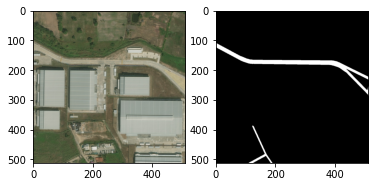

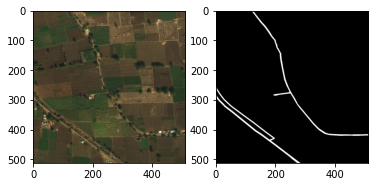

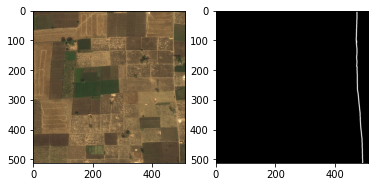

In [153]:
for image, mask in train_ds.take(3):
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(image)
  axarr[1].imshow(tf.squeeze(mask), cmap="gray")
  plt.show()

In [154]:
train_ds = train_ds.batch(BATCH_SIZE)

In [155]:
train_history = model.fit(train_ds, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, callbacks=[TensorBoard(log_dir="logs_final")])

Epoch 1/200
1/1 [==============================] - 2s 2s/step - loss: 0.9077 - accuracy: 0.9157 - iou_coef: 0.0468 - dice_coef: 0.0923 - tversky: 0.0923
Epoch 2/200
1/1 [==============================] - 1s 930ms/step - loss: 0.9202 - accuracy: 0.8658 - iou_coef: 0.0398 - dice_coef: 0.0798 - tversky: 0.0798
Epoch 3/200
1/1 [==============================] - 1s 801ms/step - loss: 0.9105 - accuracy: 0.1945 - iou_coef: 0.0451 - dice_coef: 0.0895 - tversky: 0.0895
Epoch 4/200
1/1 [==============================] - 1s 865ms/step - loss: 0.9147 - accuracy: 0.0645 - iou_coef: 0.0430 - dice_coef: 0.0853 - tversky: 0.0853
Epoch 5/200
1/1 [==============================] - 1s 869ms/step - loss: 0.9252 - accuracy: 0.0479 - iou_coef: 0.0375 - dice_coef: 0.0748 - tversky: 0.0748
Epoch 6/200
1/1 [==============================] - 1s 848ms/step - loss: 0.9255 - accuracy: 0.0465 - iou_coef: 0.0377 - dice_coef: 0.0745 - tversky: 0.0745
Epoch 7/200
1/1 [==============================] - 1s 846ms/step - 

## Visualizing the (poor) results
Here we take some of the testing images for which we don't have a ground truth mask and show how the model is basically finding roads, but it also classifies white-looking pixels as roads as well, which isn't very useful. After trying lots of learning rates, loss function parameters and using different amounts of the training data the iou_coef which I got was around 0.06

In [156]:
test_ds = tf.data.Dataset.from_tensor_slices(get_frames(TEST_DIR))

In [157]:
test_ds = test_ds.map(load_test)

In [158]:
test_ds = test_ds.map(normalize_test)

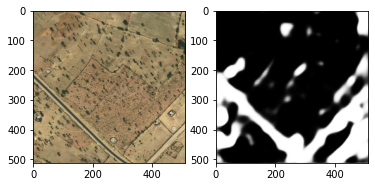

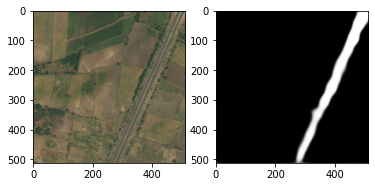

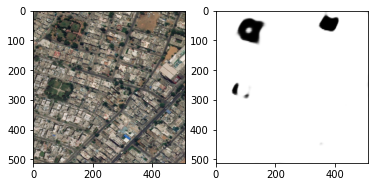

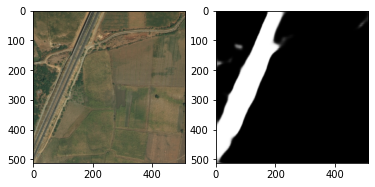

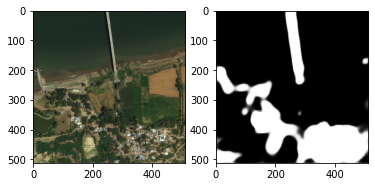

In [90]:
predictions = []
test_ds = test_ds.shuffle(50)
for image in test_ds.take(5):
  predictions.append((image, model.predict(np.expand_dims(image, axis=0))))
for image, mask in predictions:
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(image)
  axarr[1].imshow(mask.squeeze(axis=(0, 3)), cmap='gray')
  plt.show()

%tensorboard --logdir logs_final